In [61]:
import numpy as np 
import matplotlib.pyplot as plt 
#from qnetwork.dde import DDE_analytical
from qnetwork.multiphoton_ww import EmittersInWaveguideMultiphotonWW,Waveguide
from qnetwork.tools import set_plot_style
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset


In [ ]:
from numpy.polynomial import Polynomial

def DDE_analytical(gamma,phi,tau,t):
	''' returns the analitycal solution for the DDE of a single emitter in a cavity'''
	
	alpha = 1j*phi/tau + 0.5*gamma 
	result =  np.exp(-alpha*t)*np.ones(len(t),dtype=complex)
	poli = Polynomial([1])
	N = int(t[-1]/tau)
	
	for n in range(1,N+1):
		dummie = poli.integ() 
		result += np.exp(-alpha*t)*np.exp(n*alpha*tau)*dummie(-gamma*(t-n*tau))*np.heaviside(t-n*tau,1)
		poli += dummie 

		
	return result 

# Single emitter in a cavity 

The point of this section is to show
1. the qubit's dynamics is differs depending on a) the coupling strength b) where you couple the qubit with respect to the FSR 
2. The qubit's dynamics is piecewise continuous 
3. the DDE are exact in the higher energies of the spectrum 

In [ ]:
from typing import Optional 

def run_ww_simulation(t_max: Optional[float] = None , gamma :float = 0.1, Delta: float = 10.0 , L:float = 1, c: float = 1, n_steps: int = 201,n_modes=20):
	tau=2*L/c
	if t_max is None:
		t_max = 25*tau 
	setup=EmittersInWaveguideMultiphotonWW(gamma=gamma,Delta=Delta,L=L,c=c,positions=[0.0], n_modes=n_modes, n_excitations=list(range(2)))
	t,e = setup.evolve(t_max,n_steps=n_steps,initial_state="1")
	return t,e

def exp000(t_max: Optional[float] = None , gamma :float = 0.1, Delta_list: list = [10,50,100], L:float = 1, c: float = 1, n_steps: int = 201,n_modes=20):

	'''' This experiment shows the piece-wise natura of the dynamics, plus the importance of where to place the qubit in the spectrum of the cavity. '''
	tau = 2*L/c
	if t_max is None:
		t_max = 25*tau 
	fig,axs = plt.subplots(1,len(Delta_list),figsize=(8*len(Delta_list),5))

	for i,Delta in enumerate(Delta_list):
		phi = 2*np.pi*Delta 
		t,e = run_ww_simulation(t_max=t_max,gamma=gamma,Delta=Delta,L=L,c=c,n_modes=n_modes,n_steps=n_steps)
		J = DDE_analytical(gamma=gamma,phi=phi,tau=tau,t=t)
		axs[i].plot(gamma*t,e,label='Wigner-Weisskopf')
		axs[i].plot(gamma*t,np.abs(J)**2,'r--',label='DDE')
		axins = inset_axes(axs[i],width="30%",height="30%",loc="upper right")
		axins.plot(gamma*t,e,label='WW')
		axins.plot(gamma*t,np.abs(J)**2,'r--',label='DDE')
		axins.plot(gamma*t,np.exp(-gamma*t),'k-.',label=r"$ e^{-\gamma t} $")
		axins.set_yscale('log')
		axins.set_xlim(1e-2,2*gamma*tau)
		axins.set_ylim(0.5,1)
		axins.legend()
		
		axins.set_yscale('log')
		axs[i].set_xlabel(r"$\gamma t $")
		axs[i].set_title(rf"$ \Delta = {Delta:.1f}$ F.S.R. ")
		axs[i].grid()
		fig.suptitle(r"$\langle \sigma^{+}\sigma^{-} \rangle $")
		fig.tight_layout
	plt.show()
		
	


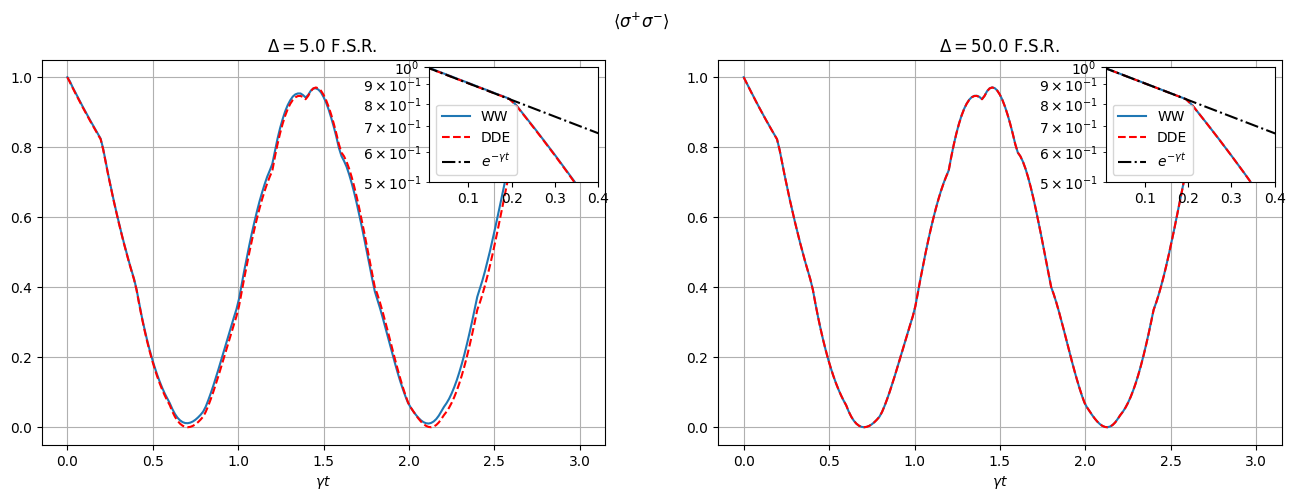

In [108]:
exp000(gamma=0.1,n_modes=100,Delta_list=[5,50],t_max=30)

In [153]:
def exp002(t_max: Optional[float] = None , gamma :float = 0.1, Delta_list: list = [5,20,50], n_modes_list: list =[20,40,60],L:float = 1, c: float = 1, n_steps: int = 201,n_modes=20):
    tau =2*L/c
    if t_max is None:
        t_max = 25*tau 

    fig,axs = plt.subplots(1,len(Delta_list),figsize=(8*len(Delta_list),5))
    
    for i,Delta in enumerate(Delta_list):
        error_nmodes=[]
        phi = 2*np.pi*Delta
        for n_modes in n_modes_list:
            t_ww,e_ww = run_ww_simulation(t_max=t_max,gamma=gamma,Delta=Delta,L=L,c=c,n_modes=n_modes,n_steps=n_steps)
            e_ww=e_ww.T[0]
            e_dde = np.abs(DDE_analytical(gamma=gamma,phi=phi,tau=tau,t=t_ww))**2
            error_nmodes.append(np.sum(np.abs(e_ww.T-e_dde))/np.sum(np.abs(e_ww)))

        axs[i].plot(n_modes_list,error_nmodes,'-o')
        axs[i].set_xlabel('number of modes')
        axs[i].set_ylabel('diference between ww and dde')
        axs[i].grid()
        axs[i].set_title(rf"$ \Delta = {Delta:.1f}$ F.S.R. ")
    fig.tight_layout()
    plt.show()



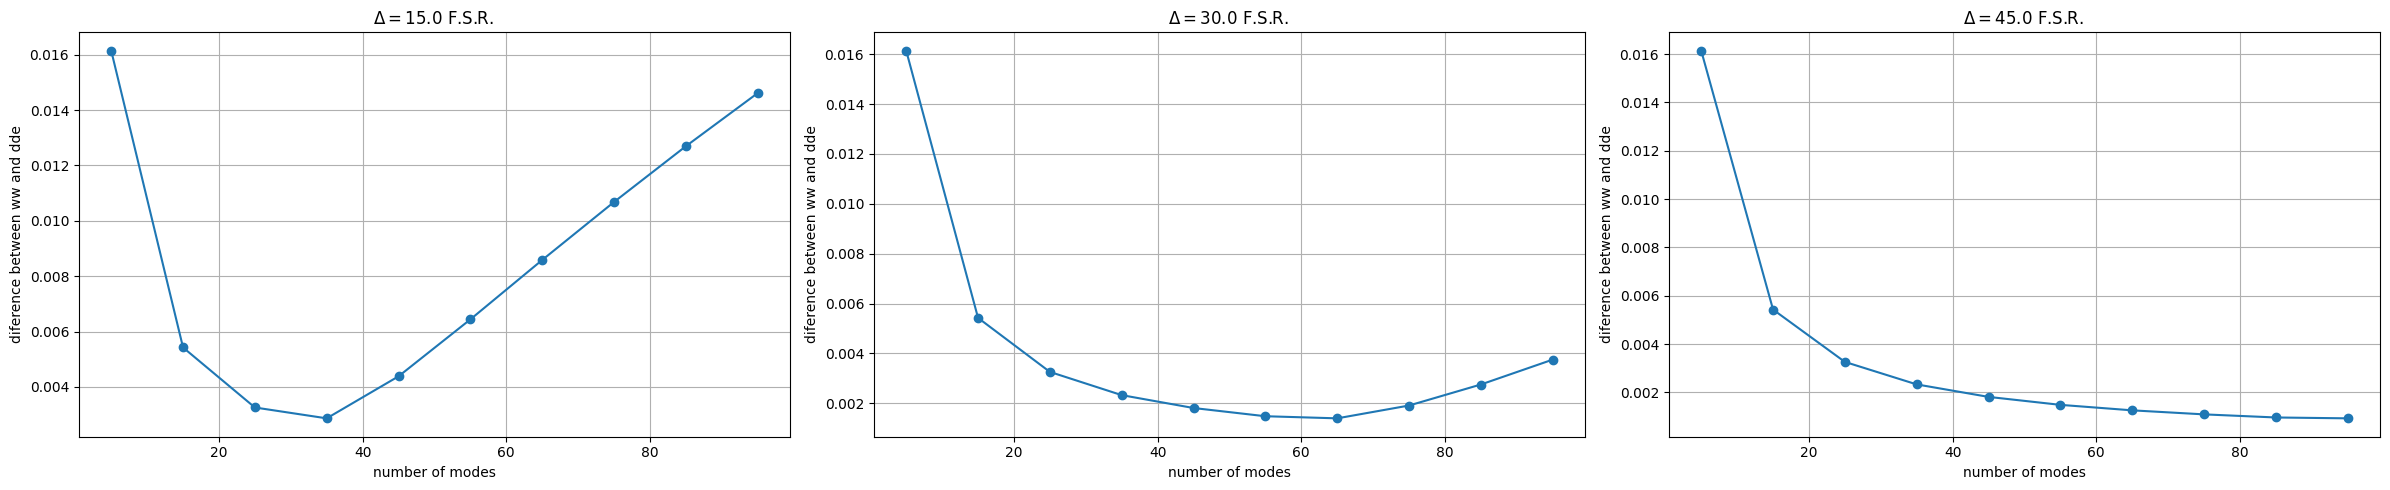

In [155]:
exp002(Delta_list=[15,30,45],n_modes_list=list(range(5,96,10)))

# On the use of the analytical solution of the DDE

I have to relate the solution of the DDE to the problem at hand. notice that the euations are 

$$ \partial_{t} \hat{c}_{1}(t) = -\frac{\gamma}{2}\hat{c}_{1}(t) - \gamma \sum_{m=1}^{\infty} e^{i(2n)\phi} \hat{c}_{1}(t-(2n)\tau) -\gamma \sum_{n=1}^{\infty}e^{i(2n-1)\phi}\hat{c}_{2}(t-(2n-1)\tau) $$

$$ \partial_{t} \hat{c}_{2}(t) = -\frac{\gamma}{2}\hat{c}_{2}(t) - \gamma \sum_{m=1}^{\infty} e^{i(2n)\phi} \hat{c}_{2}(t-(2n)\tau) -\gamma \sum_{n=1}^{\infty}e^{i(2n-1)\phi}\hat{c}_{1}(t-(2n-1)\tau) $$

also, the analytical solution for bosons requires 

$$ \hat{c}_{1}(t) = J_{11}(t)\hat{c}_{1}(0) + J_{12}(t)\hat{c}_{2}(0) $$
$$ \hat{c}_{2}(t) = J_{21}(t)\hat{c}_{1}(0) + J_{22}(t)\hat{c}_{2}(0) $$

which leads to equations for functions, rather than operators. We now have two identical systems of coupled differential equations. 

\begin{cases}
\partial_{t}J_{11}(t) = -\frac{\gamma}{2}J_{11}(t) - \gamma \sum_{m=1}^{\infty} e^{i(2n)\phi} J_{11}(t-(2n)\tau) - \gamma \sum_{n=1}^{\infty}e^{i(2n-1)\phi}J_{21}(t-(2n-1)\tau) \\
\partial_{t}J_{21}(t) = -\frac{\gamma}{2}J_{21}(t) - \gamma \sum_{m=1}^{\infty} e^{i(2n)\phi} J_{21}(t-(2n)\tau) - \gamma \sum_{n=1}^{\infty}e^{i(2n-1)\phi}J_{11}(t-(2n-1)\tau) 
\end{cases}

Is the system that we need to solve. by defining $J_{\pm}(t) = J_{11}(t) \pm J_{21}(t) $ we find that equations decouple into 

$$ \partial_{t} J_{\pm}(t) = -\frac{\gamma}{2}J_{\pm}(t) - \gamma \sum_{m=1}^{\infty} e^{i(2n)\phi} J_{\pm}(t-(2n)\tau) \mp \gamma \sum_{n=1}^{\infty}e^{i(2n-1)\phi}J_{\pm}(t-(2n-1)\tau) $$

The equation for $ J_{+}(t) $ is directly the equation for a qubit in a cavity, since we group up the even and odd terms and yield

$$ \partial_{t} J_{+}(t) = -\frac{\gamma}{2}J_{+}(t) -\gamma \sum_{n}e^{in\phi}J_{+}(t-n\tau) $$

The equation for $J_{-}(t) $ requires one extra realization, and that is the fact that if we do $\phi \to \phi + \pi$ the even terms of the summation remain unchanged, but the odd ones get an extra $e^{i\pi} = -1$, which fixes the sign issue, resulting in 

\begin{cases}
\partial_{t} J_{+}(t) = -\frac{\gamma}{2}J_{+}(t) -\gamma \sum_{n}e^{in\phi}J_{+}(t-n\tau) \\
\partial_{t} J_{-}(t) = -\frac{\gamma}{2}J_{+}(t) -\gamma \sum_{n}e^{in(\phi+\pi)}J_{-}(t-n\tau) 
\end{cases}

and 

\begin{cases}
\hat{c}_{1}(t) = \frac{J_{+}(t)+J_{-}(t)}{2} \hat{c}_{1}(0) + \frac{J_{+}(t)-J_{-}(t)}{2} \hat{c}_{2}(0) \\
\hat{c}_{2}(t) = \frac{J_{+}(t)-J_{-}(t)}{2} \hat{c}_{1}(0) + \frac{J_{+}(t)+J_{-}(t)}{2} \hat{c}_{2}(0)
\end{cases}

In [8]:
gamma= 0.01
L=2
c=1
positions=[0,L/2]
Delta=50.0

setup_ww=EmittersInWaveguideMultiphotonWW(positions=positions,gamma=gamma,Delta=Delta,L=L,c=c,setup=Waveguide.Ring)



In [30]:
t_ww,pop_ww=setup_ww.evolve(100,201,"10")
pop_ww=pop_ww.T


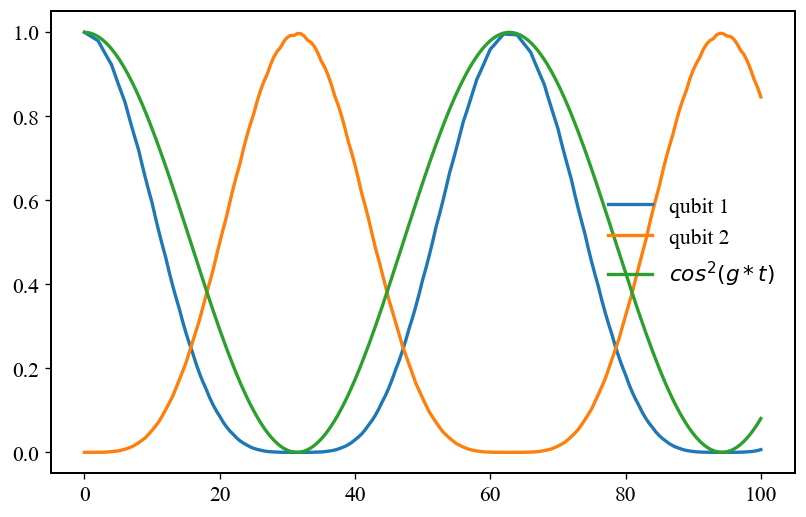

In [31]:
tau = 2*L/c 

plt.plot(t_ww,pop_ww[0],label='qubit 1')
plt.plot(t_ww,pop_ww[1],label='qubit 2')
plt.plot(t,np.cos(np.sqrt(gamma/(tau))*t)**2,label=r"$cos^{2}(g*t)$")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from numpy.polynomial import Polynomial

def DDE_analytical(gamma,phi,tau,t):
	''' returns the analitycal solution for the DDE of a single emitter in a cavity'''
	
	alpha = 1j*phi/tau + 0.5*gamma 
	result =  np.exp(-alpha*t)*np.ones(len(t),dtype=complex)
	poli = Polynomial([1])
	N = int(t[-1]/tau)
	
	for n in range(1,N+1):
		dummie = poli.integ() 
		result += np.exp(-alpha*t)*np.exp(n*alpha*tau)*dummie(-gamma*(t-n*tau))*np.heaviside(t-n*tau,1)
		poli += dummie 

		
	return result 

def analytical_2_qubits_cavity(gamma:float, phi:float, tau:float, t: list |np.ndarray) : 
	
	c_plus=DDE_analytical(gamma=gamma,phi=phi,tau=tau,t=t)
	c_minus = DDE_analytical(gamma=gamma,phi=phi+np.pi,tau=tau,t=t)
	
	pop1=np.abs(0.5*(c_plus+c_minus))**2 
	pop2=np.abs(0.5*(c_plus-c_minus))**2
	return [np.real(pop1),np.real(pop2)]
	
	

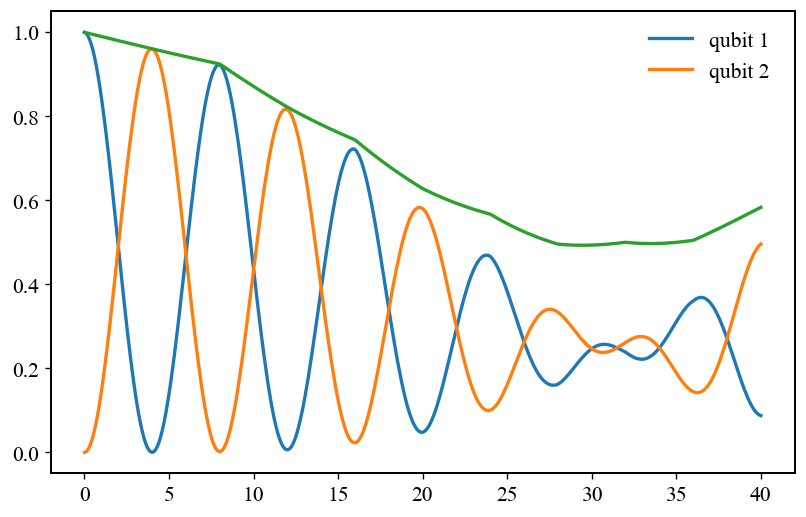

In [9]:
t=np.linspace(0,40,400)
tau=2*L/c
phi = 2*np.pi*Delta

data=analytical_2_qubits_cavity(gamma=gamma,phi=phi,tau=tau,t=t)

plt.plot(t,data[0],label='qubit 1')
plt.plot(t,data[1],label='qubit 2 ')
plt.plot(t,data[0]+data[1])
plt.legend()
plt.grid()
plt.show()

In [33]:
t=np.linspace(0,100,400)

c_plus=DDE_analytical(gamma=gamma,phi=phi,tau=tau,t=t)
c_minus = DDE_analytical(gamma=gamma,phi=phi+np.pi,tau=tau,t=t)

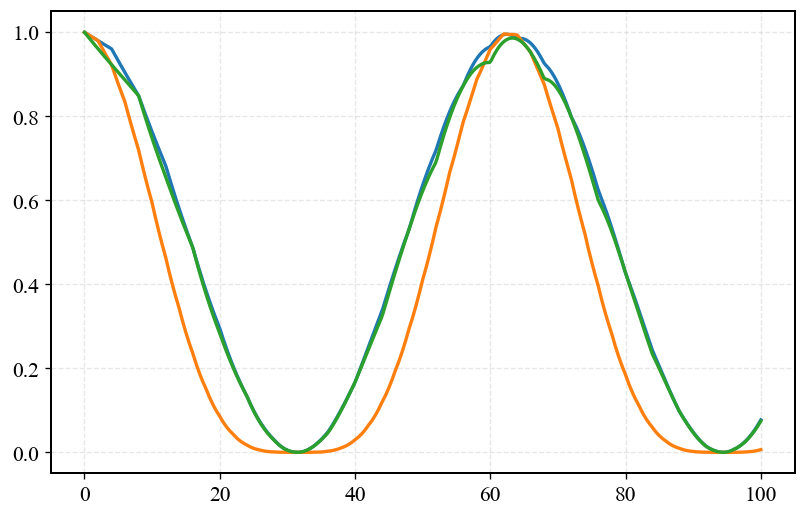

In [38]:
plt.plot(t,np.abs(c_plus)**2)
plt.plot(t_ww,pop_ww[0],label='qubit 1')
plt.plot(t,np.abs(np.conj(c_minus)*c_plus)**2)

In [6]:
gamma=0.04
phi=10*np.pi
L=1
c=1.2
tau=2*L/c

FSR = 2*np.pi / tau


positions=[0.0]
Delta=[phi/(2*np.pi)]
setup = EmittersInWaveguideMultiphotonWW(positions=positions,gamma=gamma,Delta=Delta,L=L,c=c)

In [7]:
t_max = 20
t,e=setup.evolve(t_max,initial_state="1")
e2 = DDE_analytical(gamma=gamma,phi=phi,tau=tau,t=t)

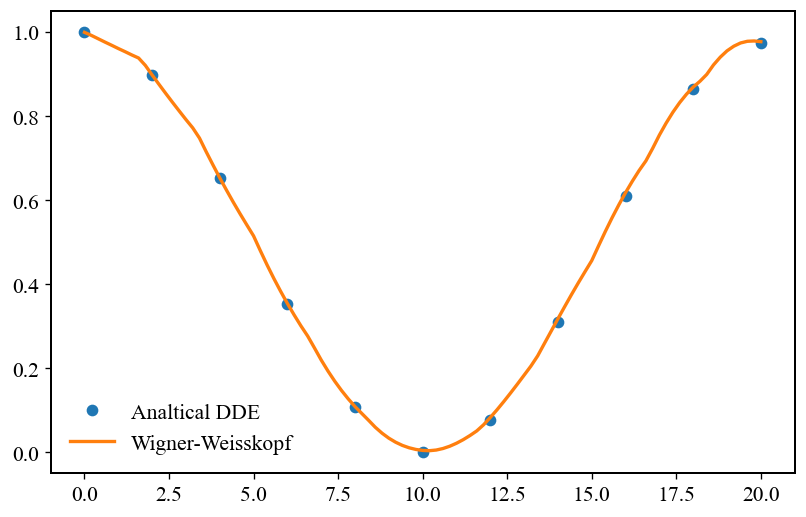

In [8]:
plt.plot(t,e2,'o',markevery=10,label='Analtical DDE ')
plt.plot(t,e,label='Wigner-Weisskopf')
plt.legend()
plt.grid()
plt.show()